# 【プロダクト演習】

## 概要
過去の株価情報をもとにLSTMを使った時系列予測を試みる。


* データ
yahoo!Financeからダウンロードとした日経225の終値をベースとする

* 予測情報
過去の株価からX営業日後の株価の上昇/下降率を予測する。
具体的には「1%以上、0%以上1%未満、0%以下-1%より上、-1%未満」に分類する。

* 目的
テクニカル分析の精度があまり出ないことは承知の上で、
時系列データの予測方法を学ぶことを主目的として行う。
様々なパラメータを操作し、精度への影響を確認する。

* 参考サイト
https://www.atmarkit.co.jp/ait/articles/1712/11/news134.html

### ライブラリのインポート

In [54]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import csv
import pandas as pd

from keras.layers.core import Activation,Dense,Dropout
from keras.models import Sequential
from keras.utils import np_utils,plot_model

from keras.layers.recurrent import LSTM
from keras.callbacks import EarlyStopping
from keras.initializers import glorot_uniform,orthogonal,TruncatedNormal

### プロット用関数
テーブルとグラフを用意

In [55]:
def create_table(col, row, data):
    fig, ax =plt.subplots(1,1)
    ax.axis('tight')
    ax.axis('off')
    ax.table(cellText=data,colLabels=col,rowLabels=row,loc="center")

    plt.show()

def create_plot(count, acc_list):
    #plt.plot(count, loss_list)
    plt.plot(count, acc_list)
    plt.legend(["accuracy"])
    plt.xlabel("#trial")
    plt.ylabel("perplexity")
    plt.show()

def plot_history(history, 
                save_graph_img_path, 
                fig_size_width, 
                fig_size_height, 
                lim_font_size):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
   
    epochs = range(len(acc))

    # グラフ表示
    plt.figure(figsize=(fig_size_width, fig_size_height))
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size'] = lim_font_size  # 全体のフォント
    #plt.subplot(121)

    # plot accuracy values
    plt.plot(epochs, acc, color = "blue", linestyle = "solid", label = 'train acc')
    plt.plot(epochs, val_acc, color = "green", linestyle = "solid", label= 'valid acc')
 
    # plot loss values
    #plt.subplot(122)
    plt.plot(epochs, loss, color = "red", linestyle = "solid" ,label = 'train loss')
    plt.plot(epochs, val_loss, color = "orange", linestyle = "solid" , label= 'valid loss')
    plt.legend()
    plt.grid()

    plt.savefig(save_graph_img_path)
    plt.close() # バッファ解放
    
    #表示
    %matplotlib inline
    plt.figure(figsize=(10, 10))
    im = Image.open(save_graph_img_path)
    im_list = np.asarray(im)
    plt.imshow(im_list)
    plt.show()

### 学習データの作成クラス
指定したCSVデータ（Yahoo!Financeから取得）をもとにデータ整形する


■パラメータ
* 予測に使用する過去日数
* テストデータの分割割合
* 変化率の予測日

■create_train_target
1. null（休業日データ)の除去
2. 終値のX日後の変化率を算出
3. one-hot表現を生成

■split_train_test
1. 学習データを訓練用とテスト用に分離

In [56]:
class CreateData:
    def __init__(self, splitrate, len_sequence, predict_day):
        self.len_sequence = len_sequence # 予測に使用する過去日数
        self.splitrate   = splitrate   # テストデータの分割割合
        self.predict_day  = predict_day  #予測日（何営業日後か）
        
    def create_train_target(self, read_file):
        # 学習データ整形
        df = pd.read_csv(read_file)
        df = df.dropna(how='any')
        df['Close_diff'] = df.Close.pct_change(periods=self.predict_day)
        df = df.dropna(how='any')*100
        x_data = df['Close_diff'].values
        print('x_data.shape=', x_data.shape)
        print('================ x_data =====================')
        print(x_data)
        print('================ x_data =====================')   
        
        # one-hot表現
        # 1%以上
        df.loc[df['Close_diff'] >= 1, '1%以上'] = 1
        df.loc[~(df['Close_diff'] >= 1), '1%以上'] = 0
        # 1%未満
        df.loc[(df['Close_diff'] >= 0) & (df['Close_diff'] < 1), '1%未満'] = 1
        df.loc[~((df['Close_diff'] >= 0) & (df['Close_diff'] < 1)), '1%未満'] = 0
        # 0%未満
        df.loc[(df['Close_diff'] < 0) & (df['Close_diff'] > -1), '0%未満'] = 1
        df.loc[~((df['Close_diff'] < 0) & (df['Close_diff'] > -1)), '0%未満'] = 0
        # -1%以下
        df.loc[df['Close_diff'] <= -1, '-1%以下'] = 1
        df.loc[~(df['Close_diff'] <= -1), '-1%以下'] = 0
        t_data = df.loc[:,['1%以上','1%未満','0%未満','0%未満']].values
        print('t_data.shape=', t_data.shape)
        print('================ t_data =====================')
        print(t_data)
        print('================ t_data =====================')       
    
        return (x_data,t_data)
        
    def split_train_test(self, x_data, t_data):
        data = []
        target = []
        for i in range(0, x_data.shape[0] - self.len_sequence + 1):
            data.append(x_data[i:i + self.len_sequence])
            target.append(t_data[i + self.len_sequence - 1, :])
        x = np.array(data).reshape(len(data), self.len_sequence, 1)
        t = np.array(target).reshape(len(data), t_data.shape[1])
            
        print(x.shape, t.shape)
    
        n_train = int(len(data) * self.splitrate) # 訓練データ長
        x_train,x_test = np.vsplit(x, [n_train])  # 学習データを訓練用とテスト用に分割
        t_train,t_test = np.vsplit(t, [n_train])  # ラベルデータを訓練用とテスト用に分割
    
        print(x_train.shape, x_test.shape, t_train.shape, t_test.shape)
        return (x_train, x_test),(t_train, t_test)



### 予測モデル
LSTMを利用。

In [57]:
class Prediction :
  def __init__(self, len_sequence, n_hidden, n_in, n_out, dropout_rate):
    self.len_sequence = len_sequence
    self.n_hidden = n_hidden
    self.n_in = n_in
    self.n_out = n_out
    self.dropout_rate = dropout_rate
    self.early_stopping_set = EarlyStopping(patience=0, verbose=1)
    self.model = None

  #モデル作成
  def create_model(self):
    model = Sequential()
    model.add(LSTM(
                    self.n_hidden,
                    batch_input_shape = (None, self.len_sequence, self.n_in),
                    kernel_initializer = glorot_uniform(seed=20170719), 
                    recurrent_initializer = orthogonal(gain=1.0, seed=20170719), 
                    dropout =self.dropout_rate, 
                    recurrent_dropout = self.dropout_rate
                  )
             )
    model.add(Dropout(self.dropout_rate))
    model.add(Dense(self.n_out, kernel_initializer = glorot_uniform(seed=20170719)))
    model.add(Activation("softmax"))
    model.compile(loss="categorical_crossentropy", optimizer = "RMSprop", metrics = ['accuracy'])
    #model.summary()
    self.model = model
    
  # 学習
  def train(self,x_train, t_train, batch_size, epochs, early_stopping_set, verbose=1) :
    early_stopping = EarlyStopping(patience=early_stopping_set, verbose=1)

    return self.model.fit(
        x_train, 
        t_train, 
        batch_size = batch_size, 
        epochs = epochs, 
        verbose = verbose, 
        shuffle = True, 
        callbacks = [early_stopping], 
        validation_split = 0.1
    )

  # テスト
  def evaluate(self, x_test, t_test, batch_size):      
    score = self.model.evaluate(x_test, t_test, batch_size = batch_size, verbose = 0)
    return score

  # 正答率集計
  def scoring(self, x_test, t_test):
    preds = self.model.predict(x_test)
    correct = 0
    for i in range(len(preds)):
      pred = np.argmax(preds[i,:])
      tar = np.argmax(t_test[i,:])
      if pred == tar :
        correct += 1

    return (1.0 * correct / len(preds))

  # 最適化
  def optimize(self, x_train, t_train, x_test, t_test, batch_size, epochs, early_stopping_set, verbose):
        # グラフ画像のサイズ
        FIG_SIZE_WIDTH = 12
        FIG_SIZE_HEIGHT = 10
        FIG_FONT_SIZE = 25
        
        # モデル生成
        self.create_model()
        
        # 学習
        history = self.train(x_train, t_train, batch_size, epochs, early_stopping_set, verbose)

        # テスト
        score = self.evaluate(x_test, t_test, batch_size)
        print("score:", score)
        
        # 正答率集計
        pred = self.scoring(x_test, t_test)

        # 学習過程をプロット
        plot_history(history, 
            save_graph_img_path = "graph.png", 
            fig_size_width = FIG_SIZE_WIDTH, 
            fig_size_height = FIG_SIZE_HEIGHT, 
            lim_font_size = FIG_FONT_SIZE) 
        
        return pred

### パラメータ最適化探索用クラス
モデルに様々なパラメータを与えて最適化なハイパーパラメータを調査するためのクラス
* search_batch_size:バッチサイズの探索用

* search_early_stopping:早期終了のpatience探索用

* search_dropout_rate:ドロップアウトの探索

* search_last_day_count:過去日数の探索

* search_hidden_unit:隠れ層のユニット数の探索


In [58]:
class OptimizeSearch :
  def __init__(self, prediction, x_train, t_train, x_test, t_test):
    self.prediction = prediction
    self.x_train = x_train
    self.t_train = t_train
    self.x_test  = x_test
    self.t_test  = t_test 

  # バッチサイズの探索
  def search_batch_size(self, epochs, early_stopping_set, batch_size_list) :
    col = ['accuracy']
    row = []
    data = []
    accuracy_list = []
    for batch_size in batch_size_list:
        print('batch_size:'+ str(batch_size))
               
        # 最適化実行
        pred = prediction.optimize(x_train, t_train, x_test, t_test, batch_size, epochs, early_stopping_set, verbose=0)
        
        #テーブルセット
        row.append(batch_size)
        data.append(pred)      
        accuracy_list.append(pred)

    create_table(col, row, data)
    create_plot(batch_size_list, accuracy_list)

    
  # 早期終了の探索
  def search_early_stopping(self, batch_size, epochs, early_stopping_list) :
    col = ['accuracy']
    row = []
    data = []
    accuracy_list = []
    for early_stopping_set in early_stopping_list:
        print('early_stopping:'+ str(early_stopping_set))
        
        # 最適化実行
        pred = prediction.optimize(x_train, t_train, x_test, t_test, batch_size, epochs, early_stopping_set, verbose=0)
        
        #テーブルセット
        row.append(early_stopping_set)
        data.append(pred)      
        accuracy_list.append(pred)
        
    create_table(col, row, data)
    create_plot(batch_size_list, accuracy_list)


  # ドロップアウトの探索
  def search_dropout_rate(self, batch_size, epochs, dropout_rate_list) :
    col = ['accuracy']
    row = []
    data = []
    accuracy_list = []
    for dropout_rate in dropout_rate_list:
        print('dropout_rate:'+ str(dropout_rate))
        
        # モデル再定義
        prediction = Prediction(len_sequence, n_hidden, 1, 4, dropout_rate)

        # 最適化実行
        pred = prediction.optimize(x_train, t_train, x_test, t_test, batch_size, epochs, early_stopping_set, verbose=0)
        
        #テーブルセット
        row.append(dropout_rate)
        data.append(pred)
        accuracy_list.append(pred)
        
    create_table(col, row, data)
    create_plot(batch_size_list, accuracy_list)
    
    
  # 過去日数の探索
  def search_last_day_count(self, batch_size, epochs, early_stopping_set, read_file, last_day_count_list) :
    col = ['accuracy']
    row = []
    data = []
    accuracy_list = []
    for last_day_count in last_day_count_list:
        print('last_day_count:'+ str(last_day_count))
        
        #データ整形と分割
        data = CreateData(
                    split_rate,
                    last_day_count,
                    predict_day
                )
        (x_data,t_data) = data.create_train_target(read_file)
        (x_train, x_test),(t_train, t_test) = data.split_train_test(x_data,t_data)        
        
        # 最適化実行
        pred = prediction.optimize(x_train, t_train, x_test, t_test, batch_size, epochs, early_stopping_set, verbose=0)
        
        #テーブルセット
        row.append(last_day_count)
        data.append(pred)      
        accuracy_list.append(pred)
        
    create_table(col, row, data)
    create_plot(batch_size_list, accuracy_list)
    

  # 隠れ層のユニット数の探索
  def search_hidden_unit(self, batch_size, epochs, hidden_unit_list) :
    col = ['accuracy']
    row = []
    data = []
    accuracy_list = []
    for hidden_unit in hidden_unit_list:
        print('hidden_unit:'+ str(hidden_unit))
        
        # モデル再定義
        prediction = Prediction(len_sequence, hidden_unit, 1, 4, 0.5)

        # 最適化実行
        pred = prediction.optimize(x_train, t_train, x_test, t_test, batch_size, epochs, early_stopping_set, verbose=0)
        
        #テーブルセット
        row.append(hidden_unit)
        data.append(pred)
        accuracy_list.append(pred)
        
    create_table(col, row, data)
    create_plot(batch_size_list, accuracy_list)

### 初期パラメータの設定ととりあえずの正答率確認

x_data.shape= (13745,)
================ x_data =====================
[ 0.49852266  0.81329995  0.95427451 ... -1.10122126 -0.36458438
 -0.41729455]
================ x_data =====================
t_data.shape= (13745, 4)
================ t_data =====================
[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 0. 0. 0.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]]
================ t_data =====================
(13666, 80, 1) (13666, 4)
(12299, 80, 1) (1367, 80, 1) (12299, 4) (1367, 4)
Train on 11069 samples, validate on 1230 samples
Epoch 1/100
11069/11069 [==============================] - 52s 5ms/step - loss: 1.7096 - accuracy: 0.2928 - val_loss: 1.4473 - val_accuracy: 0.3057
Epoch 2/100
11069/11069 [==============================] - 59s 5ms/step - loss: 1.5394 - accuracy: 0.3454 - val_loss: 1.2778 - val_accuracy: 0.3033
Epoch 3/100
11069/11069 [==============================] - 65s 6ms/step - loss: 1.4411 - accuracy: 0.3802 - val_loss: 1.0908 - val_accuracy: 0.3480
Epoch 4/100
11069/11069 

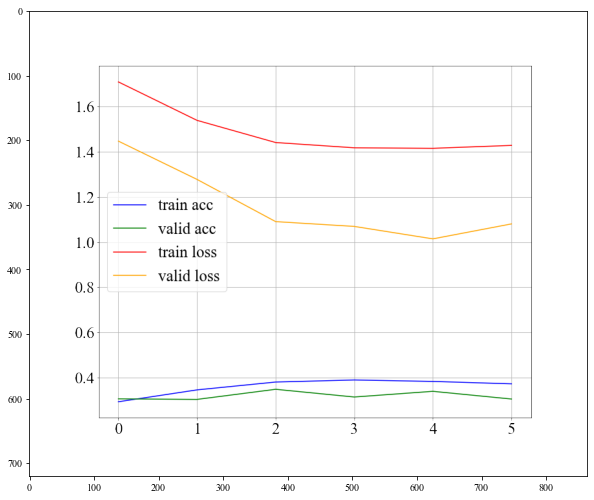

正答率: 0.36795903438185806


In [63]:
# 初期パラメータ
n_hidden     = 80  # 隠れ層のユニット数
epochs       = 100 # エポック数
batch_size   = 10  # ミニバッチサイズ
len_sequence = 80  # 参照する過去日数
predict_day  = 1   #予測日（何営業日後か）
dropout_rate = 0.5 #ドロップアウト割合
early_stopping_set = 0 # 早期終了のpatience
split_rate = 0.9 # 学習データの分割割合
verbose = 1

#データ整形と分割
data = CreateData(
            split_rate,
            len_sequence,
            predict_day
        )
(x_data,t_data) = data.create_train_target(read_file='N225.csv')
(x_train, x_test),(t_train, t_test) = data.split_train_test(x_data,t_data)

# モデル定義
prediction = Prediction(len_sequence, n_hidden, 1, 4, dropout_rate)

# 最適化実行
score = prediction.optimize(x_train, t_train, x_test, t_test, batch_size, epochs, early_stopping_set,verbose)

print("正答率:", score)


### パラメータ値検証

In [ ]:
# パラメータ検証定義[バッチサイズ]
batch_size_list = [2,5,10,20,50,100] #検証パターン
search = OptimizeSearch(prediction,x_train, t_train, x_test, t_test)
search.search_batch_size(batch_size_list, epochs, early_stopping_set)

early_stopping:0
Epoch 00007: early stopping
score: [0.85652677478281, 0.5245062112808228]


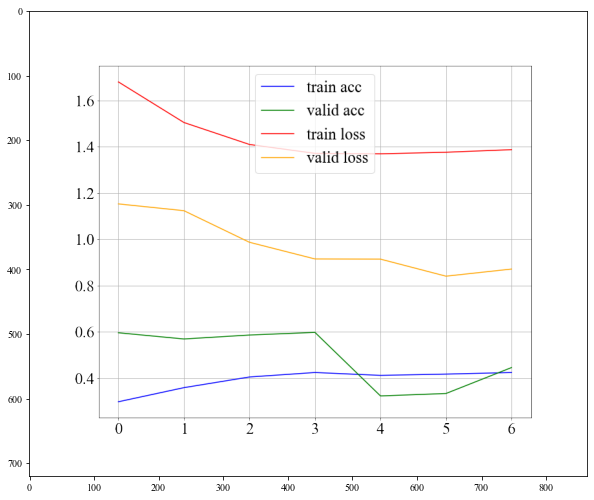

early_stopping:1


In [ ]:
# パラメータ検証定義[早期終了]
early_stopping_list = [0, 1]
search = OptimizeSearch(prediction,x_train, t_train, x_test, t_test)
search.search_early_stopping(batch_size, epochs, early_stopping_list)

In [ ]:
# パラメータ検証定義[参照する過去日数]
last_day_count_list = [1,10,25,50,80,100,200]
search = OptimizeSearch(prediction,x_train, t_train, x_test, t_test)
search.search_last_day_count(batch_size, epochs, early_stopping_set,read_file='N225.csv',last_day_count_list)

In [ ]:
# パラメータ検証定義[ドロップアウト]
dropout_list = [0,0.1,0.25,0.5,0.75]
search = OptimizeSearch(prediction,x_train, t_train, x_test, t_test)
search.search_last_day_count(batch_size, epochs, early_stopping_set, dropout_list)

In [ ]:
# パラメータ検証定義[隠れ層のユニット数]
hidden_unit_list = [10,50,80,100,150,200]
search = OptimizeSearch(prediction,x_train, t_train, x_test, t_test)
search.search_hidden_unit(self, batch_size, epochs, hidden_unit_list)